# Spectral Clustering Analysis
## Spectral Clustering algorithm from scratch .

One of the main fields in Machine learning is the field of unsupservised learning.<br>
The main idea is to find a pattern in our data without the prior knowledge of labels for example in supervised learning.<br>
It is usually achieved by clustering our data into groups.<br>
One of the more popular algorithms is the very popular K means algorithm (or the familiar EM algorithm). In this algorithm we have K centroids adjusted in an iterative process to find our clusters. sounds good right? <br>
But the main problems are:<br>
1) It makes assumption on the shape of the data (a round sphere, a radial basis)<br>
2) It requires multiple restarts at times to find the local minima (i.e. the best clustering)<br>

Spectral Clustering helps to solve these two problems.  Using a graph of the data points and <br>
The stages are:<br>
1) constructing a similarity graph (KNN graph)<br>
2) Embed the data points in low dimensional space (spectral embedding) in which the clusters are more obvious with the use of eigenvectors of the graph Laplacian.<br>
3) A classical Clustering algorithm (e.g. K - means) is applied to partition the embedding

In [507]:
%load_ext watermark
import warnings
warnings.filterwarnings("ignore") 
from IPython.core.display import display, HTML

import time

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2018-07-15T10:27:49+03:00

CPython 3.5.4
IPython 6.2.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


Exploring the spectral clustering algorithm.

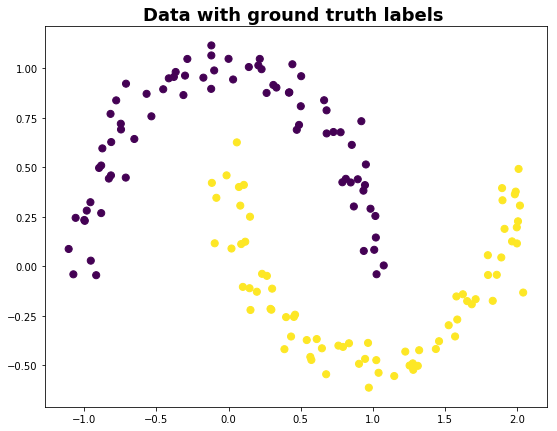

In [511]:
from sklearn.datasets import make_moons
random_state = 21
X_mn, y_mn = make_moons(150, noise=.07, random_state=random_state)
cmap = 'viridis'
dot_size=50

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Data with ground truth labels ', fontsize=18, fontweight='demi')

ax.scatter(X_mn[:, 0], X_mn[:, 1],c=y_mn,s=dot_size, cmap=cmap)

clearly, a K means algorithm won't help here since  the clusters are not spherical.<br>
Here is an example of trying to solve this clustering problem using K- means.


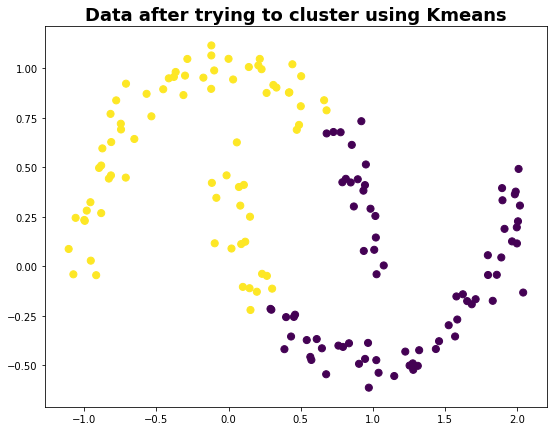

In [496]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_mn)
fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Data after trying to cluster using Kmeans', fontsize=18, fontweight='demi')

ax.scatter(X_mn[:, 0], X_mn[:, 1],c=kmeans.labels_,s=dot_size, cmap=cmap)

Let's try to follow the stages of the spectral clustering.<br>
Let's start with creating the nearest neighbours graph we need:

In [428]:
from sklearn.neighbors import radius_neighbors_graph
from sklearn.neighbors import kneighbors_graph

In [472]:
A = radius_neighbors_graph(X_mn,0.4,mode='distance', metric='minkowski', p=2, metric_params=None, include_self=False)
# A = kneighbors_graph(X_mn, 2, mode='connectivity', metric='minkowski', p=2, metric_params=None, include_self=False)
A = A.toarray()
A.shape

(150, 150)

In [473]:
A[:5,:5]

array([[0.        , 0.        , 0.        , 0.        , 0.23955829],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.23955829, 0.        , 0.        , 0.        , 0.        ]])

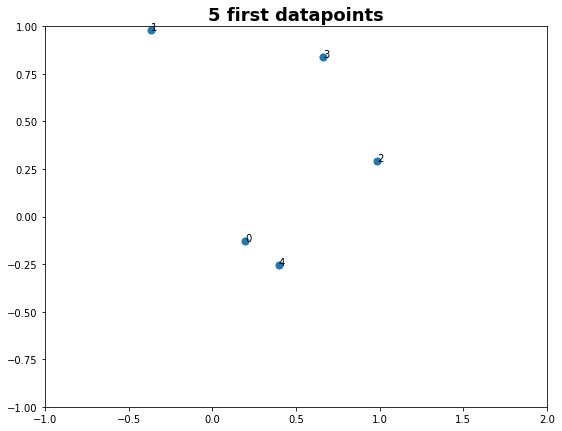

In [474]:
fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('5 first datapoints', fontsize=18, fontweight='demi')
ax.set_xlim(-1, 2)
ax.set_ylim(-1,1)
ax.scatter(X_mn[:5, 0], X_mn[:5, 1],s=dot_size, cmap=cmap)
for i in range(5):
    ax.annotate(i, (X_mn[i,0],X_mn[i,1]))

So we have here our adjacency matrix (50x50), which depicts the distances between each point to another,we set a limit to connect only the 25 nearest points, so all other weights (between the point  will be zero.<br>
Let's take a look at the relationship of the first 5 data points.<br>
The diagonal in the matrix is zero since every point is not connected to itself. Notice that it is also symmetrical from the nature of our data (e.g. weight between point 1 and 2 is the same as 2 and 1).<br>
Every number represents the weight (the distance) between the two points, as you can see points 1 and 2 are very close and the weight is 0.2143.<br>
But point 0 and point 3 are quite far away so the weight is 0 (in simple words, point 0 is not one of the closest 25 points to point 3).<br>
<br>

Ok, so we are done with building our nearest neighbours graph (equivelent to our adjacency matrix), <br>
Let's move on to our Laplacian.<br>
The Laplacian is defined as the L=D-A where A is our adjecency matrix we just saw and D is a diagonal matrix.<br>
D is the "degree matrix" , every cell in the diagonal is the sum of the weights for that  point. <br>
For example,D(1,1) is the sum of all weights between point 1 and all other points (so it is the sum of row number 1 in the adjacency matrix).<br>
The same for D(2,2) and so on. D(I,J) when I is different than J is 0.

In [475]:
from scipy.sparse import csgraph
from sklearn.cluster import KMeans
L = csgraph.laplacian(A, normed=False)

In [476]:
L[:5,:5],

(array([[ 3.8892734 , -0.        , -0.        , -0.        , -0.23955829],
        [-0.        ,  3.40126844, -0.        , -0.        , -0.        ],
        [-0.        , -0.        ,  3.00486906, -0.        , -0.        ],
        [-0.        , -0.        , -0.        ,  3.45831612, -0.        ],
        [-0.23955829, -0.        , -0.        , -0.        ,  4.06569259]]),)

In [477]:
B = np.sum(A,axis=0)
B[:2]

array([3.8892734 , 3.40126844])

So I used the built in function of scipy for laplacian, as you can see the Laplacian values on the diagonal are the degree matrix, and the rest are the weights from the adjacency matrix with the minus sign due to our formula.<br>

Next we are going to embed the data points in a low dimensional space(spectral embedding), in which the clusters are more *obvious* with the use of eigenvectors of the graph laplacian.

In [513]:
eigval, eigvec = np.linalg.eig(L)
kmeans = KMeans(n_clusters=2, random_state=0).fit(eigvec)
# kmeans

In [516]:
np.where(eigval == np.partition(eigval, 1)[1]) 

((array([0], dtype=int64),),
 (array([6], dtype=int64),),
 0.03098972875873049,
 (array([1], dtype=int64),))

In [485]:
eigval[:20]

array([-1.33920652e-15,  3.09897288e-02,  1.26309658e-01,  1.61499165e-01,
        4.43825692e-01,  5.82521350e-01,  6.74514701e+00,  1.01824273e+00,
        1.16903130e+00,  1.34766710e+00,  6.32972566e+00,  6.20550519e+00,
        1.58755522e+00,  1.69464645e+00,  5.94723886e+00,  5.94017533e+00,
        5.84882863e+00,  5.77774310e+00,  5.71152497e+00,  5.44922770e+00])

In [486]:
eigvec[3]

array([-8.16496581e-02, -6.50452416e-02, -9.54270622e-02, -4.81422791e-02,
        4.70127577e-02,  9.73107702e-03,  2.22259737e-06,  1.60521800e-01,
        2.98776353e-02,  5.33885832e-02, -3.68793655e-02,  6.82503362e-04,
        1.54935573e-01, -5.09990254e-03, -5.17998325e-02,  1.47600468e-02,
       -4.16481280e-02,  2.55500671e-02,  1.10182626e-01,  9.15063934e-03,
        1.96342780e-02,  7.97045058e-04,  5.58115113e-03,  1.86976586e-03,
        5.34649687e-02, -1.00826049e-01,  5.74619881e-03,  3.98974570e-02,
       -3.16111655e-02, -2.32944319e-02, -2.81643434e-02, -2.11019304e-02,
        7.77073393e-02,  2.16993895e-04, -1.26997019e-03,  2.20672792e-02,
        4.40736621e-03,  2.35474216e-02,  4.78082842e-03, -2.39693108e-02,
       -5.15340866e-03, -8.32125285e-03,  8.75436352e-04,  4.08518755e-03,
        2.19015849e-03,  2.09198351e-02,  5.45501946e-03,  4.02612385e-02,
       -8.05743144e-04, -1.68807867e-02, -1.10066937e-02, -3.63346249e-02,
        9.09916819e-03, -

In [491]:
y_spec =eigvec[:,1].copy()
y_spec[y_spec < 0] = 0
y_spec[y_spec > 0] = 1

In [492]:
type(y_spec),y_mn.shape,y_spec.shape

(numpy.ndarray, (150,), (150,))

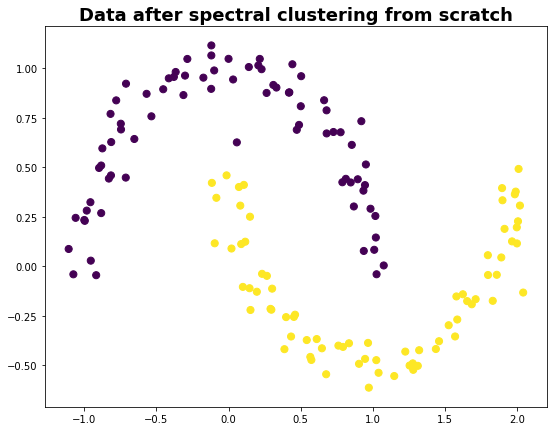

In [517]:
fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Data after spectral clustering from scratch', fontsize=18, fontweight='demi')
ax.scatter(X_mn[:, 0], X_mn[:, 1],c=y_spec ,s=dot_size, cmap=cmap)

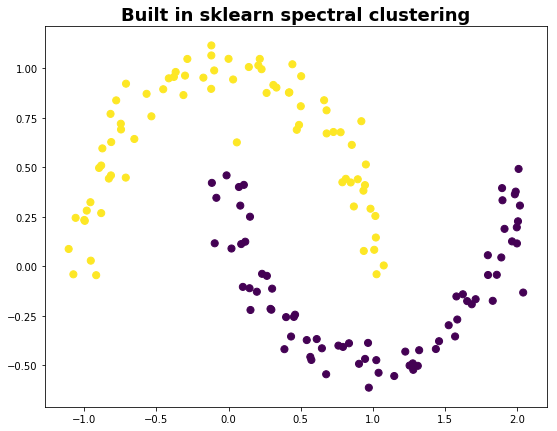

In [519]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                          assign_labels='kmeans')

labelsS = model.fit_predict(X_mn)

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Built in sklearn spectral clustering', fontsize=18, fontweight='demi')
plt.scatter(X_mn[:, 0], X_mn[:, 1], c=labelsS, s=dot_size, cmap=cmap)

In [424]:
model

SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
          coef0=1, degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=2, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=None)